In [ ]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import time
import numpy as np
import h5py

np.random.seed(4)

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.size'] = 10
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from sklearn.decomposition import PCA

from joblib import Parallel, delayed
from skimage.io import imread

from canon.common.init import init_logging
init_logging()

from canon.autoencode.report import backend_report
backend_report()

from canon.pattern.model import GMModel, KMeansModel, BGMModel, MeanShiftModel
from canon.seq.seqreader import SeqReader
from canon.pattern.labeler import SeqLabeler
from canon.pattern import LatentExtractor
from canon.util import split_workload
from canon.autoencode.report import is_using_gpu

PARALLELISM = 1 if is_using_gpu() else -1

def read_seq(seq, key="orsnr___"):
    seqfile = os.path.join("seq", seq+".SEQ")
    reader = SeqReader(seqfile)    
    Z = reader.get_Zmap(key, thres=0)[0]
    return Z[::-1, :]

def fill_features(features, img_shape):
    num_points = np.prod(img_shape)
    if len(features) != num_points:
        print("Filling %d features to %d data points" % (len(features), num_points))
        features2 = np.zeros((np.prod(img_shape), features.shape[1] - 1))
        features2[features[:, 0].astype('int') - 1] = features[:, 1:]
        return features2
    else:
        return features[:, 1:]
    
def xy_to_idx(x, y, img_shape):
    return y * img_shape[1] + x

def idx_to_xy(idx, img_shape, flip_vertical=True):
    x = int(idx / img_shape[1])
    y = idx % img_shape[1]
    if flip_vertical:
        x = img_shape[0] - x - 1
    return y, x

def process_img(img_files, model_name):
    extractor = LatentExtractor(model_name)
    img_data = np.array([imread(f) for f in img_files])
    img_idx = np.array([[int(f[-9:-4])] for f in img_files])
    codes = extractor.features(img_data)
    return np.hstack([img_idx, codes])

def extract_features(jpg_dir, model_name):
    dir_path = os.path.join("img", jpg_dir)
    filenames = [os.path.join(dir_path, filename) for filename in os.listdir(dir_path)
                 if (not filename[0] == '.') and filename[-4:] == ".jpg"]
    print('Found %d files in the directory %s.' % (len(filenames), dir_path))

    if PARALLELISM == 1:
        data = process_img(filenames, model_name)
        data = data[data[:,0].argsort()]
    else:
        fn_grps = split_workload(filenames, 64)
        with Parallel(n_jobs=PARALLELISM, verbose=1) as parallel:
            data = parallel(delayed(process_img)(grp, model_name) for grp in fn_grps)
            data = np.vstack(data)
    data = data[data[:,0].argsort()]
    print("Loaded a data of shape {}".format(data.shape))
    
    return data

2025-04-28 16:38:04.708250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-28 16:38:04.721390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-28 16:38:04.725170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 16:38:04.735832: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 16:38:05,663 [MainThread

## Feature Extraction

In [2]:
t0 = time.time()

jpg_dir = "Au30"
# jpg_dir = "Au324_RT"

# models = ["ae_conv_4_256_best"]
models = ["resnet50_256"]

features = []
for model in models:
    print("Extracting features from {} using {} ...".format(jpg_dir, model))
    data = extract_features(jpg_dir, model)
    features.append(data)

hdf5_file = jpg_dir +'.hdf5'
print("Save {} datasets to {}".format(len(features), hdf5_file))
with h5py.File(os.path.join("features", hdf5_file), 'w') as h5f:
    for m, d in zip(models, features):
        print(m, d.shape)
        h5f.create_dataset(m, data=d)
with h5py.File(os.path.join("features", hdf5_file), 'r') as h5f:
    print("Final datasets in {}: {}".format(hdf5_file, list(h5f.keys())))
    
print("%.2f" % (time.time() - t0))

Extracting features from Au30 using resnet50_256 ...
Found 2000 files in the directory img/Au30.


I0000 00:00:1745883488.459753  209428 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745883488.459944  209428 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745883488.460002  209428 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745883488.611644  209428 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1745883488.611784  209428 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28

[<InputLayer name=ae_input, built=True>, <Concatenate name=to_rgb, built=True>, <ZeroPadding2D name=conv1_pad, built=True>, <Conv2D name=conv1_conv, built=True>, <ZeroPadding2D name=pool1_pad, built=True>, <MaxPooling2D name=pool1_pool, built=True>, <BatchNormalization name=conv2_block1_preact_bn, built=True>, <Activation name=conv2_block1_preact_relu, built=True>, <Conv2D name=conv2_block1_1_conv, built=True>, <BatchNormalization name=conv2_block1_1_bn, built=True>, <Activation name=conv2_block1_1_relu, built=True>, <ZeroPadding2D name=conv2_block1_2_pad, built=True>, <Conv2D name=conv2_block1_2_conv, built=True>, <BatchNormalization name=conv2_block1_2_bn, built=True>, <Activation name=conv2_block1_2_relu, built=True>, <Conv2D name=conv2_block1_0_conv, built=True>, <Conv2D name=conv2_block1_3_conv, built=True>, <Add name=conv2_block1_out, built=True>, <BatchNormalization name=conv2_block2_preact_bn, built=True>, <Activation name=conv2_block2_preact_relu, built=True>, <Conv2D name=con

I0000 00:00:1745883493.161994  209513 service.cc:146] XLA service 0x7ff9940037f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745883493.162037  209513 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-04-28 16:38:13.236526: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-28 16:38:13.681454: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90800


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Loaded a data of shape (10, 257)
Save 1 datasets to Au30.hdf5
resnet50_256 (10, 257)
Final datasets in Au30.hdf5: ['resnet50_256']
9.01


I0000 00:00:1745883497.410673  209513 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [3]:
feature_file="Au30"
img_shape = (37, 56)
aspect_ratio = 1
seqs = ["C5_30x30"]

ae_models = []
features = []

with h5py.File(os.path.join("features", feature_file +'.hdf5'), 'r') as h5f:
    for k in h5f.keys():
        print(k)
        data = np.array(h5f.get(k))
        print(data.shape)
        features.append(fill_features(data, img_shape))
        ae_models.append(k)
print("Read {} datasets for models {}".format(len(features), ae_models))

resnet50_256
(10, 257)
Filling 10 features to 2072 data points
Read 1 datasets for models ['resnet50_256']


## Direct Coloring
Directly color each point using the first 3 principal components, without clustering.

2025-04-28 16:38:28,927 [MainThread] DEBUG matplotlib.font_manager:1471 - findfont: Matching serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-04-28 16:38:28,928 [MainThread] DEBUG matplotlib.font_manager:1483 - findfont: score(FontEntry(fname='/home/ysong/projects/canon/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-04-28 16:38:28,929 [MainThread] DEBUG matplotlib.font_manager:1483 - findfont: score(FontEntry(fname='/home/ysong/projects/canon/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-04-28 16:38:28,930 [MainThread] DEBUG matplotlib.font_manager:1483 - findfont: score(FontEntry(fname='/home/ysong/projects/canon/venv/lib/python3.12/site-packages/matplotlib/mpl-

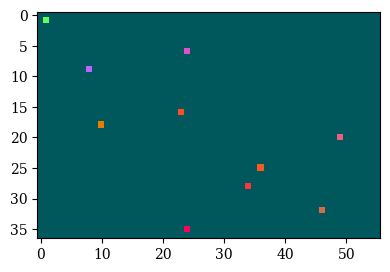

In [4]:
def draw_direct_color(features, ax):
    pca = PCA(n_components=3)
    X = pca.fit_transform(features)
    pca_range = [X.min(axis=0), X.max(axis=0)]
    X = (X - pca_range[0]) / (pca_range[1] - pca_range[0])
    Z = np.zeros((img_shape[0], img_shape[1], 3))
    Z[:, :, 0] = X[:, 0].reshape(img_shape)
    Z[:, :, 1] = X[:, 1].reshape(img_shape)
    Z[:, :, 2] = X[:, 2].reshape(img_shape)
    img = Z[::-1, :, :]
    ax.imshow(img, aspect=aspect_ratio)
    return img

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))
f = features[0]
img_dc = draw_direct_color(f, ax)
ax.axis('on')
plt.tight_layout()
# fig.savefig("img/Au30_Direct_Color.pdf", dpi=300)

## Clustering
The normal clustering + labeling

In [20]:
dataset = 0
ae_model = ae_models[dataset]
samples = features[dataset]

mPCA = None
K = 16
N = samples.shape[0]

model = KMeansModel()
if mPCA is not None and mPCA < samples.shape[1]:
    pca = PCA(n_components=mPCA)
    preprocessors = [pca]
else:
    preprocessors=[]

t0 = time.time()
if N > 6400:
    print("To many feature vectors, pick 6400 samples to train clustering")
    training_set = samples[np.random.choice(np.arange(N), 6400)]
else:
    training_set = samples
model.train(training_set, n_clusters=K, preprocessors=preprocessors)
scores = np.array(model.score(samples))
print("train and score:", time.time() - t0)

silhouette = model.compute_silhouette_score(samples)
calinski = model.compute_calinski_harabaz_score(samples)
print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

fig, ax = plt.subplots(ncols=1, nrows=1)

Z = model.color_by_pca(scores.reshape(img_shape), scaling='centroids')
ax.imshow(Z[::-1, :, :], aspect=aspect_ratio)
ax.axis('off')
plt.tight_layout()
# fig.savefig("img/C5_3.pdf", dpi=300)

train and score: 0.08783817291259766


NameError: name 'calinski_harabaz_score' is not defined

In [11]:
img_k16 = Z[::-1, :, :]

## Indexing Labeler

Requires SEQ file(s)

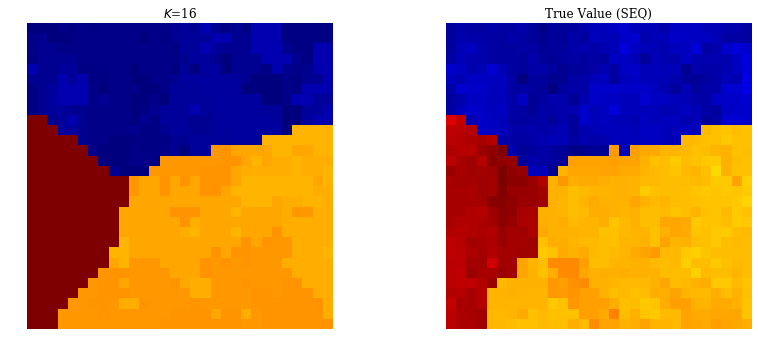

In [12]:
Z = read_seq(seqs[0])
vmax, vmin = Z.max(), Z.min()
seqfiles = [os.path.join("seq", seq+".SEQ") for seq in seqs]
labler = SeqLabeler(seqfiles, nidx_thres=6)
Z_seq = labler.Z_map()
mask = np.where(np.isfinite(Z_seq))
vmin, vmax = Z_seq[mask].min(), Z_seq[mask].max()

Z = model.score_by_seqs(samples, seqfiles)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
ax[0].imshow(Z[::-1, :], cmap='jet', aspect=1)
ax[0].axis('off')
ax[0].set_title(r'$K$=%d' % K, fontsize=12)
ax[1].imshow(Z_seq[::-1, :], cmap='jet', aspect=1)
ax[1].axis('off')
ax[1].set_title(r'True Value (SEQ)', fontsize=12)
plt.tight_layout()

In [15]:
img_seq_k16=Z[::-1, :]
img_seq=Z_seq[::-1, :]

# Silhouette Score & Calinski-Harabaz Score
Use Silhouette Score & Calinski-Harabaz Score to estimate number of "coarse" clusters.
Good for grain boundaries and phase boundaries.

In [ ]:
from joblib import Parallel, delayed

dataset = -1
ae_model = ae_models[dataset]
samples = features[dataset]

Ks = np.arange(2, 20, 1)
SCs=[]
N = len(samples)

def sc_scores(K):
    print("K=", K)
    model = KMeansModel()
    pca = PCA(n_components=32)
    if N > 6400:
        print("To many feature vectors, pick 6400 samples to train clustering")
        training_set = samples[np.random.choice(np.arange(N), 6400)]
    else:
        training_set = samples
    model.train(training_set, n_clusters=K, preprocessors=preprocessors)
    silhouette = model.compute_silhouette_score(samples)
    calinski = model.compute_calinski_harabasz_score(samples)
    print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))
    return silhouette, calinski

with Parallel(n_jobs=PARALLELISM, verbose=1) as parallel:
    SCs = parallel(delayed(sc_scores)(k) for k in Ks)
    SCs = np.array(SCs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  18 | elapsed:    0.7s remaining:    1.4s


AttributeError: 'KMeansModel' object has no attribute 'compute_calinski_harabasz_score'

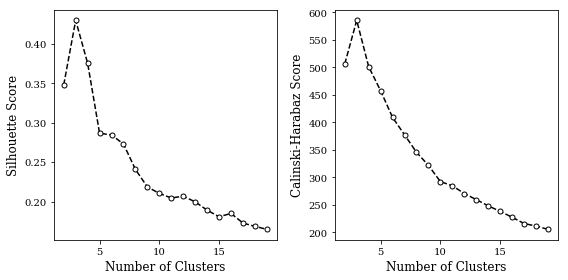

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(Ks, SCs[:, 0], 'o--k', markerfacecolor='w', markersize=5)
ax[0].set_xlabel(r'Number of Clusters', fontsize=12)
ax[0].set_ylabel(r'Silhouette Score', fontsize=12)

ax[1].plot(Ks, SCs[:, 1], 'o--k', markerfacecolor='w', markersize=5)
ax[1].set_xlabel(r'Number of Clusters', fontsize=12)
ax[1].set_ylabel(r'Calinski-Harabaz Score', fontsize=12)

plt.tight_layout()
fig.savefig("img/C5_SCH.pdf", dpi=300)

## Combine

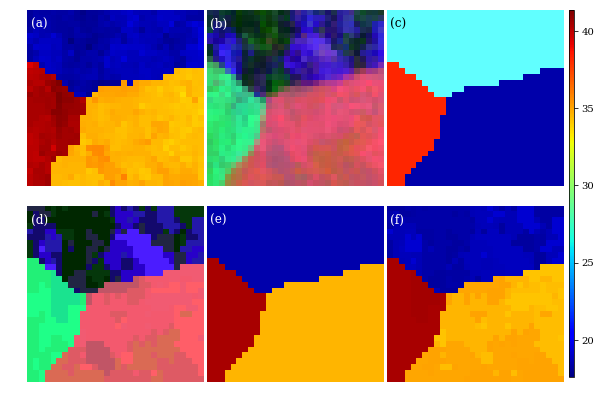

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for ax in axes.flatten():
    ax.axis('off')
    
ax = axes[0, 0]
img = ax.imshow(img_seq, cmap='jet', vmin=vmin, vmax=vmax, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(a)', transform=ax.transAxes, fontsize=12, color='w')

ax = axes[0, 1]
ax.imshow(img_dc, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(b)', transform=ax.transAxes, fontsize=12, color='w')

ax = axes[0, 2]
ax.imshow(img_k3, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(c)', transform=ax.transAxes, fontsize=12, color='k')

ax = axes[1, 0]
ax.imshow(img_k16, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(d)', transform=ax.transAxes, fontsize=12, color='w')

ax = axes[1, 1]
ax.imshow(img_seq_k3, cmap='jet', vmin=vmin, vmax=vmax, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(e)', transform=ax.transAxes, fontsize=12, color='w')

ax = axes[1, 2]
ax.imshow(img_seq_k16, cmap='jet', vmin=vmin, vmax=vmax, aspect=aspect_ratio)
ax.text(0.02, 0.9, '(f)', transform=ax.transAxes, fontsize=12, color='w')

fig.subplots_adjust(bottom=0, top=0.9, left=0, right=0.93, wspace=0.02, hspace=0.01)
cb_ax = fig.add_axes([0.94, 0.03, 0.01, 0.85])
cbar = fig.colorbar(img, cax=cb_ax)

fig.savefig("img/C5.pdf", dpi=300)